# Note:
The geographic locations of participating households, used to conduct spatial analyses, cannot be publicly available due to data privacy and ethical considerations. Regarding the built environment data, the latter is under copyrights, and hence, cannot be publicly distributed.

In [1]:
import os
from pathlib import Path
from os import path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal
import random
import seaborn as sbn

from esda.join_counts_local import Join_Counts_Local
from matplotlib import colors
from pysal.explore import esda
from pysal.lib import weights
from pysal.viz import splot
from scipy.spatial import distance
from splot.esda import plot_moran

# 1. Input

In [2]:
cwd = os.getcwd()
root_dir = Path(cwd).parent

In [3]:
## Survey data

# Individual data
data_IND_tot = pd.read_csv(path.join(root_dir,
                                    "data/raw/individual_data.csv"))

# Household data
data_HH_tot = pd.read_csv(path.join(root_dir,
                                    "data/raw/household_data.csv"))


## Households' geographic locations (confidential, not publicly accessible)

# Azito
azito = gpd.read_file(path.join(root_dir,
                                "data_confidential/preprocessed/data_AZ_HH_and_DiarrCases_blr.gpkg"))

basename_azito = os.path.basename(path.join(root_dir,"data_confidential/preprocessed/data_AZ_HH_and_DiarrCases_blr.gpkg"))

# Williamsville
willy = gpd.read_file(path.join(root_dir,
                                "data_confidential/preprocessed/data_WI_HH_and_DiarrCases_blr.gpkg"))
basename_willy = os.path.basename(path.join(root_dir,"data_confidential/preprocessed/data_WI_HH_and_DiarrCases_blr.gpkg"))

# 2. Spatial statistics: spatial autocorrelation of diarrhoea and lack of water
See Refs:  
https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#binary-case-join-counts  
https://pysal.org/esda/notebooks/localjoincounts.html

In [4]:
# Set number of neighbours for weight matrix (K-nearest neighbours)
# Note: "n" must result from a balance between significant number of observations and
#       limited maximum distances to neighbours (which must remain at local scale, e.g., 100 m radius)
n_neighbours = 16

In [5]:
# Set significance threshold
signif_thres = 0.05 # set to conventional threshold (5%)

## 2.1. Spatial autocorrelation - Azito

In [6]:
## Dummy dataframe

# Copy original df
db = azito.copy()

# Set metric CRS
db = db.to_crs(3857)

# Check
db

,uuid,PARENT_KEY,Site,HH_Number,DrinkingWaterGroup,DrinkingWater_Private,DrinkingWater_Public,DrinkingWaterDist,DrinkingWaterPaySocial,DrinkingWaterAvailability,...,San_Record_location-Latitude,San_Record_location-Longitude,Child_U5,D_Case_Tt,D_Case_U5,ID,SurveyArea,WCdirtyB,WCdirtyS,geometry
0,51e3d6c74bba45febd33457e11a9b459,uuid:464423ec-b7a0-4924-b3e4-ce85bb6a5286,Azito,252,Private,Piped_dwel,None,NaN,Y,N,...,NaN,NaN,0.0,0.0,NaN,0,AZ2,NaN,NaN,POINT (-454433.206 591096.602)
1,51e3d6c74bba45febd33457e11a9b459,uuid:b3296fc2-e492-42ae-adb3-7bd1d50ce72e,Azito,796,Private,Piped_dwel,None,NaN,N,N,...,NaN,NaN,0.0,1.0,NaN,1,AZ1,NaN,NaN,POINT (-454412.460 591466.456)
2,51e3d6c74bba45febd33457e11a9b459,uuid:ecad555f-212d-4188-9228-bb80e0fcba51,Azito,1,Private,Piped_dwel,None,NaN,N,Y,...,NaN,NaN,0.0,0.0,NaN,2,AZ1,NaN,NaN,POINT (-454568.437 591389.611)
3,51e3d6c74bba45febd33457e11a9b459,uuid:9c38f788-bf34-4a13-a70e-782eea816703,Azito,628,Private,Piped_dwel,None,NaN,Y,N,...,NaN,NaN,0.0,0.0,NaN,3,AZ3,NaN,NaN,POINT (-454298.600 591172.748)
4,51e3d6c74bba45febd33457e11a9b459,uuid:5af42a84-d16f-465c-bd56-8e8a07b2dda1,Azito,234,Private,Piped_yard,None,NaN,None,N,...,NaN,NaN,0.0,0.0,NaN,4,AZ2,0.0,0.0,POINT (-454414.808 591152.593)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,51e3d6c74bba45febd33457e11a9b459,uuid:cd50052a-2795-433b-b8a0-92eb85c63299,Azito,317,Private,Piped_dwel,None,NaN,Y,N,...,NaN,NaN,0.0,0.0,NaN,261,AZ4,NaN,NaN,POINT (-454457.469 590972.622)
262,51e3d6c74bba45febd33457e11a9b459,uuid:bb858c3f-1211-4233-824b-e897f86ff8cc,Azito,235,Private,Piped_dwel,None,NaN,N,N,...,NaN,NaN,0.0,1.0,NaN,262,AZ2,NaN,NaN,POINT (-454421.665 591156.020)
263,51e3d6c74bba45febd33457e11a9b459,uuid:c1bd4c27-54ec-44f6-9556-10a2bf5378b9,Azito,203,Private,Piped_dwel,None,NaN,Y,N,...,NaN,NaN,0.0,0.0,NaN,263,AZ2,NaN,NaN,POINT (-454532.172 591060.219)
264,51e3d6c74bba45febd33457e11a9b459,uuid:052f17ac-206a-42b8-ba91-19116d92cc4a,Azito,204,Private,Piped_dwel,None,NaN,Y,N,...,NaN,NaN,0.0,1.0,NaN,264,AZ2,NaN,NaN,POINT (-454533.945 591071.874)


Number of observations without any neighbors (islands): 0
Maximum number of neighbours: 16
Mean number of neighbours: 16.0
Minimum number of neighbours: 16
Maximum distance between neighbours: 168.2578760586748
Mean distance between neighbours: 36.89794071719917
Median distance between neighbours: 36.12141236898919


<AxesSubplot:>

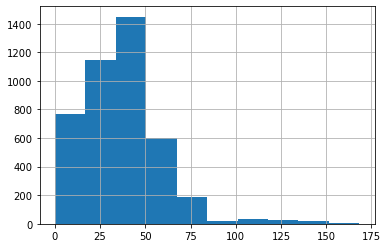

In [7]:
## Spatial matrix (neighbour connections)

# Set up KNN matrix with max. search radius set at 100m, based on point geodataframe
wq = weights.KNN.from_dataframe(db, k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

## Matrix characteristics

# Islands
print('Number of observations without any neighbors (islands):', len(wq.islands))

# Min/Max number of neighbours
print('Maximum number of neighbours:', wq.max_neighbors)
print('Mean number of neighbours:', wq.mean_neighbors)
print('Minimum number of neighbours:', wq.min_neighbors)


## Distances beetween points

# Get the coordinates of all observations
coords = weights.util.get_points_array(db.geometry)

# Maximum distance
max_distance = 0
for i, row in enumerate(wq.full()[0]):
    for j, weight in enumerate(row):
        if weight:
            dist = distance.euclidean(coords[i], coords[j])
            if dist > max_distance:
                max_distance = dist                
print('Maximum distance between neighbours:', max_distance)

# Mean & median distances
df_dist = pd.DataFrame()
for i, row in enumerate(wq.full()[0]):
    for j, weight in enumerate(row):
        if weight:
            dist = distance.euclidean(coords[i], coords[j])
            if dist > 0:
                df_dist = df_dist.append([dist])                
df_dist.columns = ['dist']
print('Mean distance between neighbours:', df_dist.dist.mean())
print('Median distance between neighbours:', df_dist.dist.median())

# Plot distance histogram
df_dist.dist.hist()

### 2.1.1. Test spatial autocorrelation for all cases (Azito)

no. observations (general pop.): 266


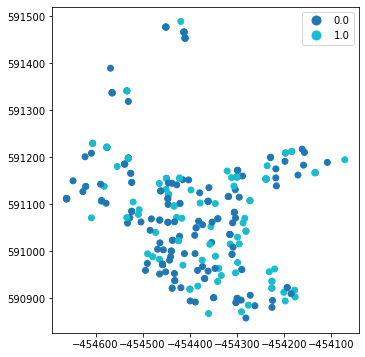

bb: 298.5
ww: 802.0
bw: 1027.5
Pval for BB: 0.956
Globally, join counts suggest NO spatial correlation


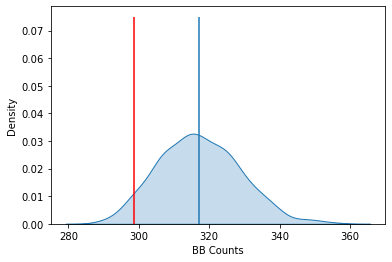

In [8]:
## Global Join counts

# Get data
var = 'D_Case_Tt'
print('no. observations (general pop.):',db.shape[0])

# See map
db.plot(aspect=1,
        column=var,
        categorical=True,
        legend=True,
        figsize=(14, 6))
plt.show()

# Set up and run join counts
np.random.seed(12345)
yb = db[var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)

# Inference:
if (jc.p_sim_bb < 0.05) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb < 0.05) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

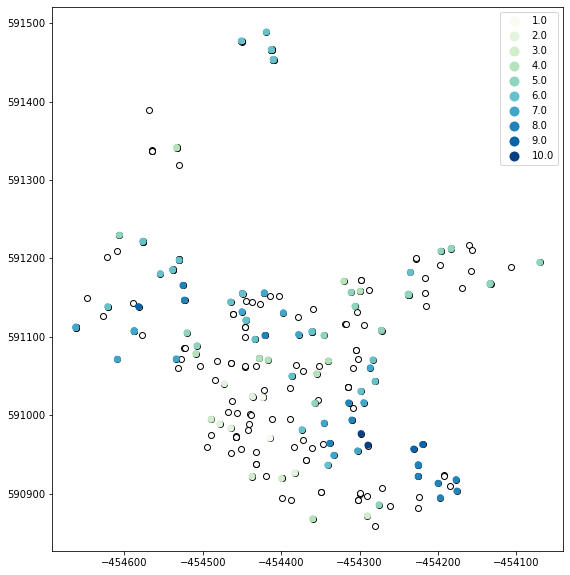

Number of significant points (LJC): 13


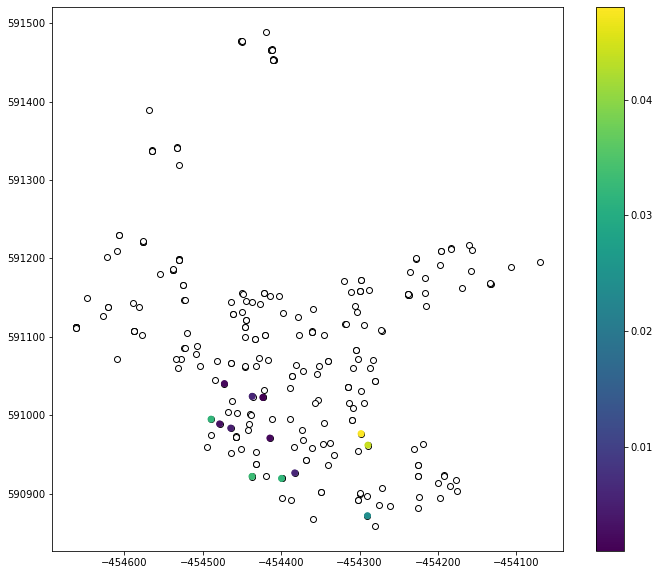

In [9]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
db['LJC_Dia'] = np.nan
db['LJC_Dia'][db[var]==1] = ljc.LJC[db[var]==1].astype('int')
db['LJC_Dia_p_sim'] = np.nan
db['LJC_Dia_p_sim'][db[var]==1] = ljc.p_sim[db[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_Dia_W'] = np.nan
db['LJC_Dia_W'][db['LJC_Dia_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_Dia_p_sim'])/signif_thres))*
                                                     db['LJC_Dia'])
db['LJC_Dia_W'][db['LJC_Dia_p_sim']>=signif_thres] = np.square((1-db['LJC_Dia_p_sim'])*
                                                      db['LJC_Dia'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db.plot(aspect=1,color='white', edgecolor='black', ax=ax)
db.plot(aspect=1,
        column='LJC_Dia',
        categorical=True,
        cmap='GnBu',
        legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_Dia_p_sim_sig'] = 0
db['LJC_Dia_p_sim_sig'][db['LJC_Dia_p_sim'] < signif_thres] = 1
if db['LJC_Dia_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db.plot(aspect=1,color='white', edgecolor='black', ax=ax)
    db[db['LJC_Dia_p_sim_sig']==1].plot(aspect=1,
                                        column='LJC_Dia_p_sim',
                                        legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_Dia_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_Dia_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.1.2. Test local spatial autocorrelation for cases amongst under-5 (Azito)

no. observations (concerning under-5 pop.): 105


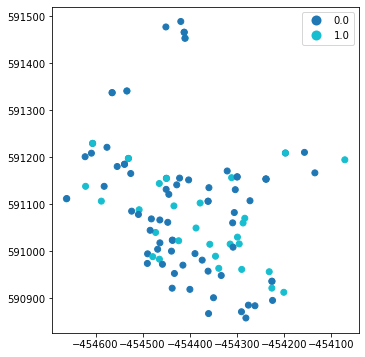

bb: 82.5
ww: 409.5
bw: 348.0
Pval for BB: 0.16
Pval for BW: 0.845
Globally, join counts suggest NO spatial correlation


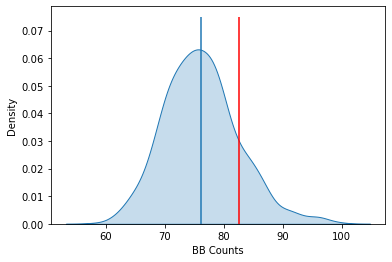

In [10]:
## Global join counts

# Get data
mask = (~db['D_Case_U5'].isna())
var = 'D_Case_U5'
print('no. observations (concerning under-5 pop.):',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

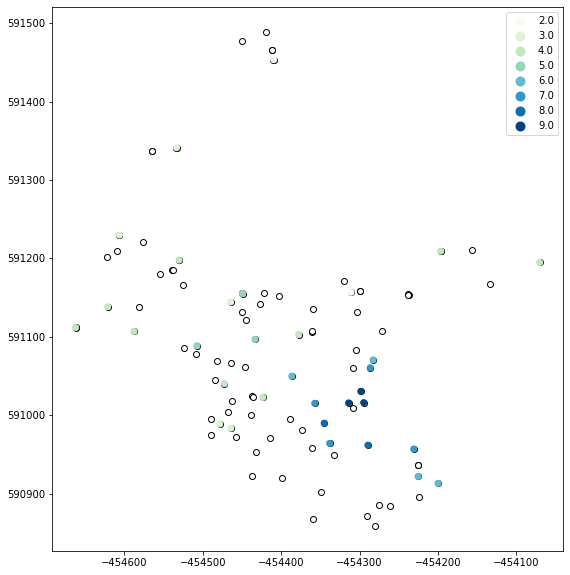

Number of significant points (LJC): 7


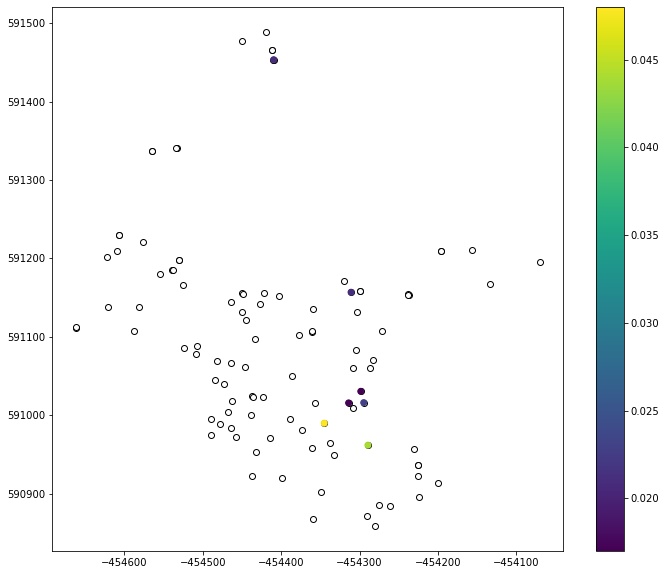

In [11]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_DiaU5'] = np.nan
db['LJC_DiaU5'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_DiaU5_p_sim'] = np.nan
db['LJC_DiaU5_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_DiaU5_W'] = np.nan
db['LJC_DiaU5_W'][db['LJC_DiaU5_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_DiaU5_p_sim'])/signif_thres))*
                                                         db['LJC_DiaU5'])
db['LJC_DiaU5_W'][db['LJC_DiaU5_p_sim']>=signif_thres] = np.square((1-db['LJC_DiaU5_p_sim'])*
                                                          db['LJC_DiaU5'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_DiaU5',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_DiaU5_p_sim_sig'] = np.nan
db['LJC_DiaU5_p_sim_sig'][mask] = 0
db['LJC_DiaU5_p_sim_sig'][db['LJC_DiaU5_p_sim'] < signif_thres] = 1
if db['LJC_DiaU5_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_DiaU5_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_DiaU5_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_DiaU5_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_DiaU5_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.1.3 Test local spatial autocorrelation for access to basic WASH services (Azito)

In [12]:
## WASH components (water, sanitation and hygiene)

# Recode access to "basic water" (following JMP definition) VS any other service type (including unimproved)
wt_basic_mask = (((db["DrinkingWaterGroup"]=='Private')&
                  (db["DrinkingWater_Private"].isin(['Piped_dwel','Piped_yard'])))|
                 ((db["DrinkingWaterGroup"]=='Private')&
                  (db["DrinkingWater_Private"].isin(['Piped_neigh']))&
                  (db["DrinkingWaterDist"]<=30))|
                 ((db["DrinkingWaterGroup"]=='Public')&
                  (db["DrinkingWater_Public"].isin(['Vendor','Ground_tube']))&
                  (db["DrinkingWaterDist"]<=30)))
db["BasicWt"] = np.nan
db["BasicWt"][~db["DrinkingWaterGroup"].isna()] = 0
db["BasicWt"][wt_basic_mask] = 1

# Recode sanitation variable: "basic" sanitation (according to WHO-UNICEF's JMP) VS any other facitilty type (including unimproved and O.D.)
basic_sn_mask = ((((db.ToiletFacilityTYPE=='DryOrCompost')&
                   (db.ToiletFacilityTYPE_Dry.isin(['Dry_ImprSlab',
                                                    'Dry_VIP'])))|
                  ((db.ToiletFacilityTYPE=='Flush')&
                   (db.ToiletFacilityTYPE_Flush.isin(['Flush_piped',
                                                      'Flush_septic_tank',
                                                      'Flush_coveredPit']))))&
                 (db.ToiletROOF=='Y')&
                 (db.ToiletFacilitySHARE=='N'))
db["BasicSan"] = np.nan
db["BasicSan"][(~db.ToiletFacility.isna())] = 0
db["BasicSan"][basic_sn_mask] = 1

# Recode "basic" hygiene (according to WHO-UNICEF's JMP)
basic_hg_mask = ((db["ObsHandWashWATER"]=='Water_OK')& # water available at the moment of the survey
                 (db["ObsHandWashSOAP"]=='SoapOrDeterg')& # soap (or equivalent) available at the moment of the survey
                 (db["ObsHandWashPLACE"]=='Obs_Fixed')) # presence of fixed structure to wash hands
db["BasicHyg"] = np.nan
db["BasicHyg"][(~db["ObsHandWashWATER"].isna())&(~db["ObsHandWashSOAP"].isna())&(~db["ObsHandWashPLACE"].isna())] = 0
db["BasicHyg"][basic_hg_mask] = 1


## General WASH

# Recode access to all 3 basic WASH services (water, sanitation and hygiene)
basic_wash_mask = ((db["BasicWt"]==1)&
                   (db["BasicSan"]==1)&
                   (db["BasicHyg"]==1))
db["BasicWASH"] = np.nan
db["BasicWASH"][(~db["BasicWt"].isna())&(~db["BasicSan"].isna())&(~db["BasicHyg"].isna())] = 0
db["BasicWASH"][basic_wash_mask] = 1

no. of valid observations: 246


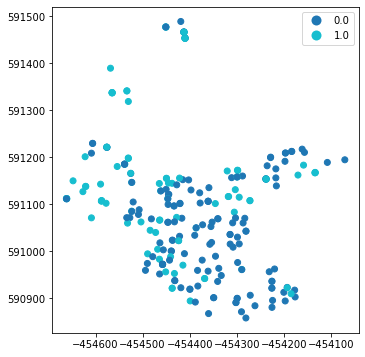

bb: 392.0
ww: 837.0
bw: 739.0
Pval for BB: 0.001
Pval for BW: 1.0
Globally, join counts suggest positive spatial correlation


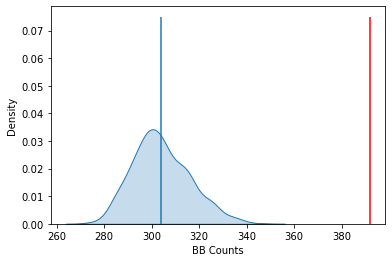

In [13]:
## Global join counts

# Get data
mask = (~db['BasicWASH'].isna())
var = 'BasicWASH'
print('no. of valid observations:',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

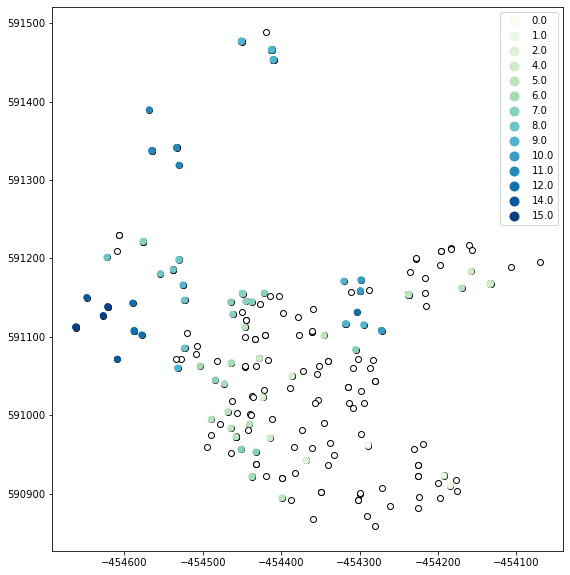

Number of significant points (LJC): 35


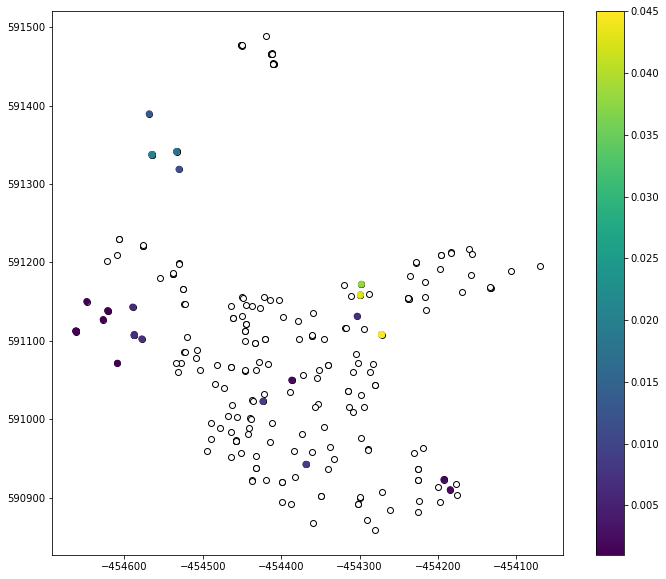

In [14]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_BsWASH'] = np.nan
db['LJC_BsWASH'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_BsWASH_p_sim'] = np.nan
db['LJC_BsWASH_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_BsWASH_W'] = np.nan
db['LJC_BsWASH_W'][db['LJC_BsWASH_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_BsWASH_p_sim'])/signif_thres))*
                                                           db['LJC_BsWASH'])
db['LJC_BsWASH_W'][db['LJC_BsWASH_p_sim']>=signif_thres] = np.square((1-db['LJC_BsWASH_p_sim'])*
                                                            db['LJC_BsWASH'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_BsWASH',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_BsWASH_p_sim_sig'] = np.nan
db['LJC_BsWASH_p_sim_sig'][mask] = 0
db['LJC_BsWASH_p_sim_sig'][db['LJC_BsWASH_p_sim'] < signif_thres] = 1
if db['LJC_BsWASH_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_BsWASH_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_BsWASH_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_BsWASH_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_BsWASH_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.1.4 Test local spatial autocorrelation for precarious housing materials (Azito)

In [15]:
# Recode precarious housing (based on dwelling's materials)
prec_h_mask = ((db["HHEXTWALLS"].isin(['Stone_mud','ReusedWoodOrBamboo','Metal']))|
               (db["HHFLOOR"].isin(['Other']))|
               (db["HHROOF"].isin(['Rustic_metal','Rustic_toles_fibr','Rustic_planks','Rustic_plastic'])))
db["PrecHHMat"] = np.nan
db["PrecHHMat"][(~db["HHEXTWALLS"].isna())&(~db["HHFLOOR"].isna())&(~db["HHROOF"].isna())] = 0
db["PrecHHMat"][prec_h_mask] = 1

no. of valid observations: 266


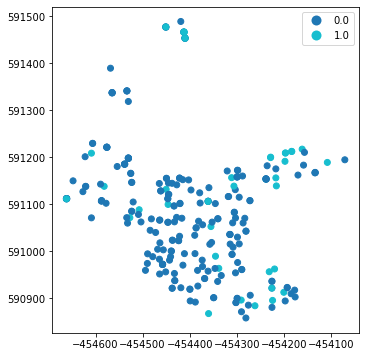

bb: 110.5
ww: 1542.5
bw: 475.0
Pval for BB: 0.001
Pval for BW: 1.0
Globally, join counts suggest positive spatial correlation


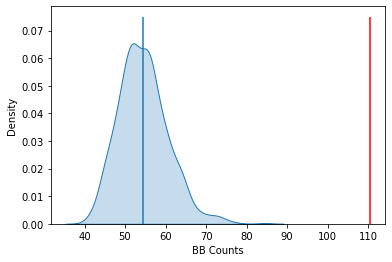

In [16]:
## Global join counts

# Get data
mask = (~db['PrecHHMat'].isna())
var = 'PrecHHMat'
print('no. of valid observations:',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

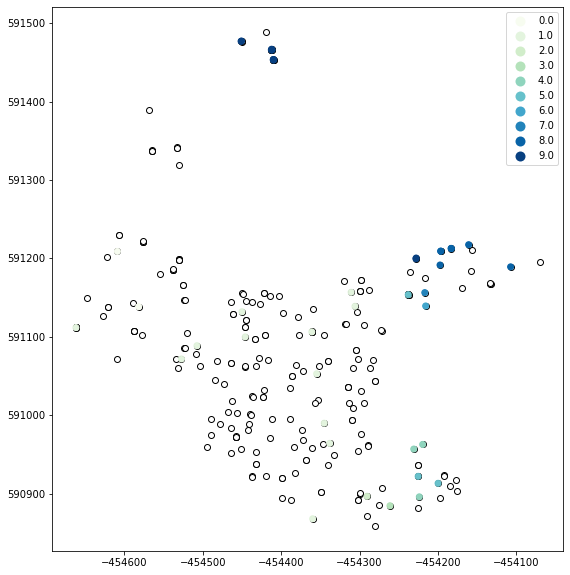

Number of significant points (LJC): 21


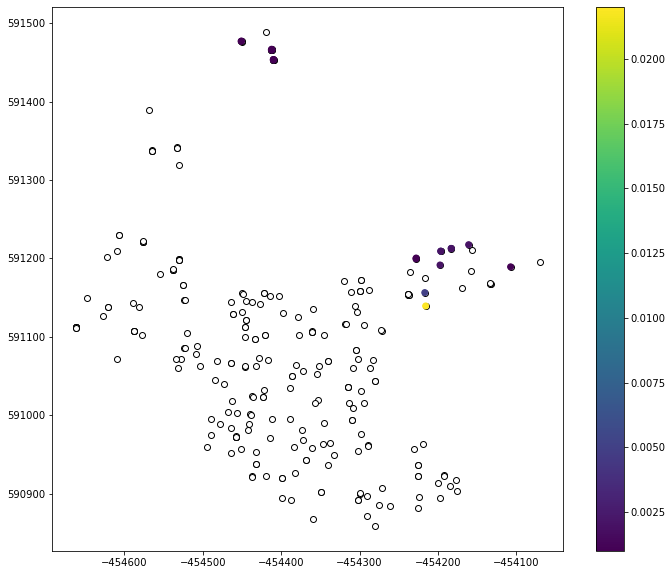

In [17]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_PrMat'] = np.nan
db['LJC_PrMat'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_PrMat_p_sim'] = np.nan
db['LJC_PrMat_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_PrMat_W'] = np.nan
db['LJC_PrMat_W'][db['LJC_PrMat_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_PrMat_p_sim'])/signif_thres))*
                                                                  db['LJC_PrMat'])
db['LJC_PrMat_W'][db['LJC_PrMat_p_sim']>=signif_thres] = np.square((1-db['LJC_PrMat_p_sim'])*
                                                                   db['LJC_PrMat'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_PrMat',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_PrMat_p_sim_sig'] = np.nan
db['LJC_PrMat_p_sim_sig'][mask] = 0
db['LJC_PrMat_p_sim_sig'][db['LJC_PrMat_p_sim'] < signif_thres] = 1
if db['LJC_PrMat_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_PrMat_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_PrMat_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_PrMat_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_PrMat_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.1.5 Test local spatial autocorrelation for indoors cooking (Azito)

In [18]:
# Cooking area (whether cooking is done inside dwelling or elsewhere)

# Note: on the contrary of the aORs in Notebooks 1a & b, here we observe households that cooked OUTSIDE
# this is necessary because there are more households cooking inside than outside the dwelling
# ('1' values must be minority in LJC analyses)

# Recode cooking area
cook_mask = (db["HHCOOKING"].isin(['Outdoors','Separate_Building']))# cooking done OUTSIDE dwelling
db["CookInsd"] = np.nan
db["CookInsd"][~db["HHCOOKING"].isna()] = 0
db["CookInsd"][cook_mask] = 1

no. of valid observations: 266


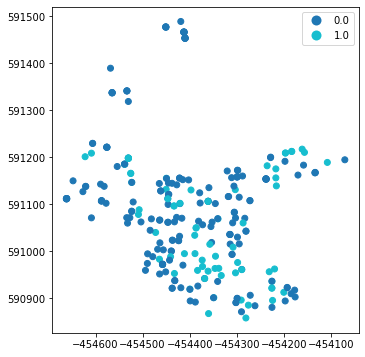

bb: 210.5
ww: 1199.0
bw: 718.5
Pval for BB: 0.001
Pval for BW: 1.0
Globally, join counts suggest positive spatial correlation


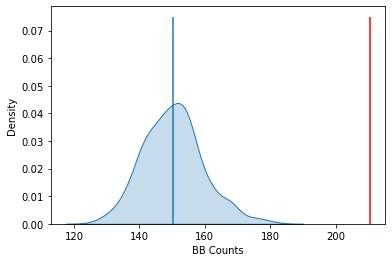

In [19]:
## Global join counts

# Get data
mask = (~db['CookInsd'].isna())
var = 'CookInsd'
print('no. of valid observations:',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

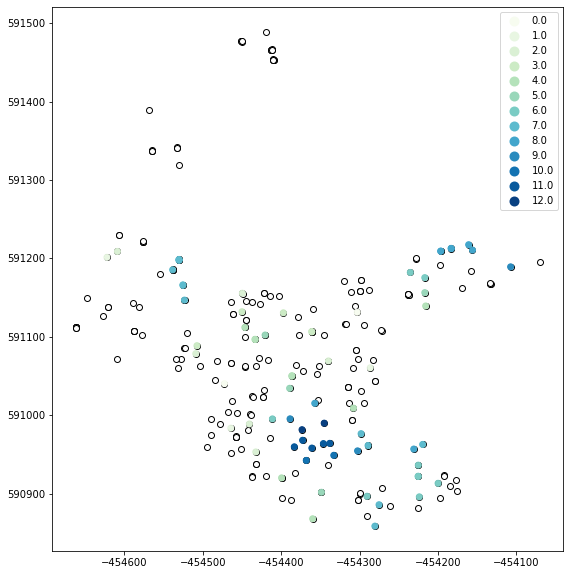

Number of significant points (LJC): 26


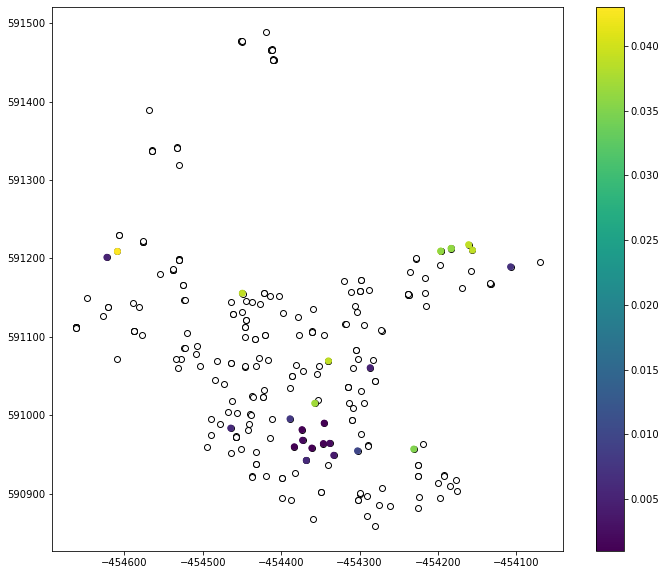

In [20]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_CkInd'] = np.nan
db['LJC_CkInd'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_CkInd_p_sim'] = np.nan
db['LJC_CkInd_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_CkInd_W'] = np.nan
db['LJC_CkInd_W'][db['LJC_CkInd_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_CkInd_p_sim'])/signif_thres))*
                                                                  db['LJC_CkInd'])
db['LJC_CkInd_W'][db['LJC_CkInd_p_sim']>=signif_thres] = np.square((1-db['LJC_CkInd_p_sim'])*
                                                                   db['LJC_CkInd'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_CkInd',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_CkInd_p_sim_sig'] = np.nan
db['LJC_CkInd_p_sim_sig'][mask] = 0
db['LJC_CkInd_p_sim_sig'][db['LJC_CkInd_p_sim'] < signif_thres] = 1
if db['LJC_CkInd_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_CkInd_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_CkInd_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_CkInd_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_CkInd_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.1.6 Test local spatial autocorrelation for lack of water (Azito)

In [21]:
## Water availability in the month preceding the survey

# Note: on the contrary of the aORs in Notebooks 1a & b, here we observe households that LACKED water
# this is necessary because there are more households with sufficient water than lacking water
# ('1' values must be minority in LJC analyses)

# Recode water availability in the past month (self-reported)
wt_avail_mask = (db["DrinkingWaterAvailability"]=='Y') # LACK of water in the previous month
db["AvailblWtM"] = np.nan
db["AvailblWtM"][~db["DrinkingWaterAvailability"].isna()] = 0
db["AvailblWtM"][wt_avail_mask] = 1

no. of valid observations: 265


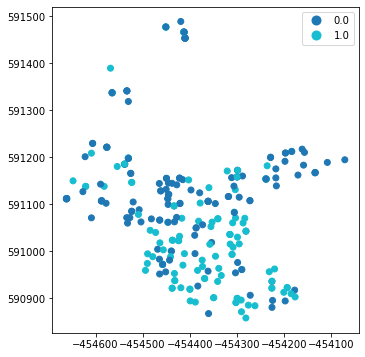

bb: 574.0
ww: 715.5
bw: 830.5
Pval for BB: 0.001
Pval for BW: 1.0
Globally, join counts suggest positive spatial correlation


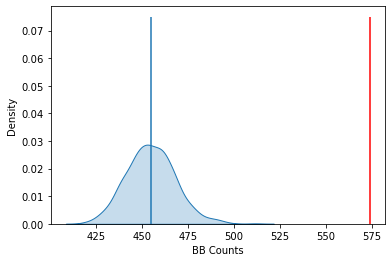

In [22]:
## Global join counts

# Get data
mask = (~db['AvailblWtM'].isna())
var = 'AvailblWtM'
print('no. of valid observations:',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

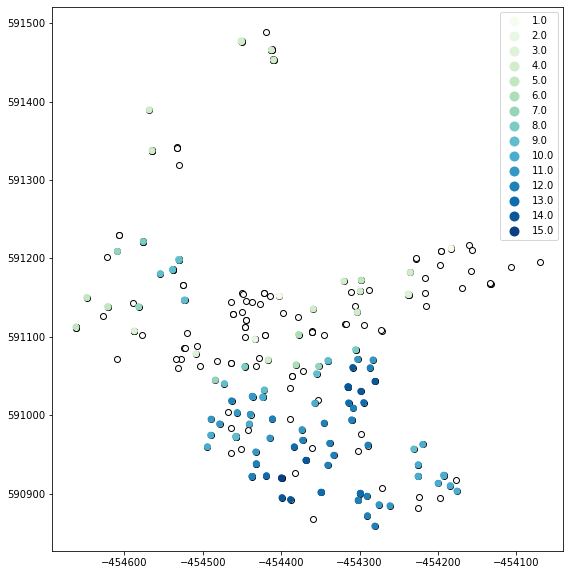

Number of significant points (LJC): 72


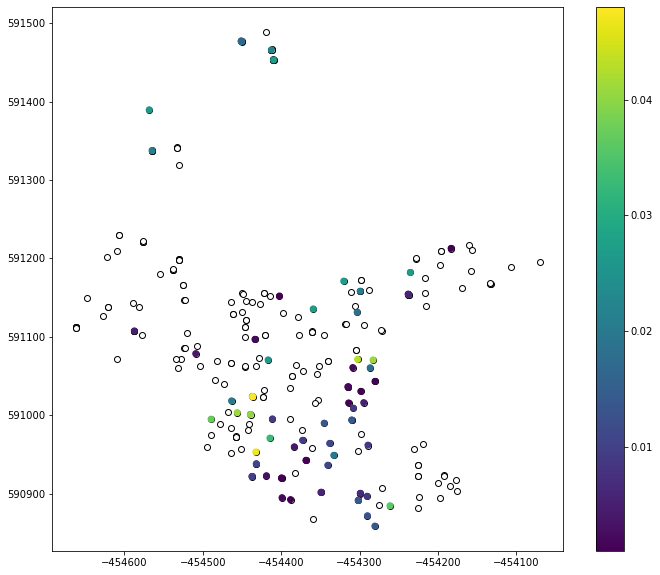

In [23]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_WtAvbM'] = np.nan
db['LJC_WtAvbM'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_WtAvbM_p_sim'] = np.nan
db['LJC_WtAvbM_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_WtAvbM_W'] = np.nan
db['LJC_WtAvbM_W'][db['LJC_WtAvbM_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_WtAvbM_p_sim'])/signif_thres))*
                                                           db['LJC_WtAvbM'])
db['LJC_WtAvbM_W'][db['LJC_WtAvbM_p_sim']>=signif_thres] = np.square((1-db['LJC_WtAvbM_p_sim'])*
                                                            db['LJC_WtAvbM'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_WtAvbM',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_WtAvbM_p_sim_sig'] = np.nan
db['LJC_WtAvbM_p_sim_sig'][mask] = 0
db['LJC_WtAvbM_p_sim_sig'][db['LJC_WtAvbM_p_sim'] < signif_thres] = 1
if db['LJC_WtAvbM_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_WtAvbM_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_WtAvbM_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_WtAvbM_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_WtAvbM_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.1.7 Test local spatial autocorrelation for 'high' socioeconomic status (Azito)

In [24]:
# Set threshold for asset-based wealth
df_c = data_HH_tot.copy()
df_c["ItemsScore"]=(df_c["HHITEMS/Computer"]+df_c["HHITEMS/Electricity"]+
                    df_c["HHITEMS/Internet"]+df_c["HHITEMS/Oven"]+
                    df_c["HHITEMS/Radio"]+df_c["HHITEMS/Refrigerator"]+
                    df_c["HHITEMS/Smartphone"]+df_c["HHITEMS/Television"])
df_c["ItemsScore"][(df_c["HHITEMS/Noitems"]==1)] = 0
df_c["ItemsScore"][(df_c["HHITEMS/NA"]==1)] = np.nan
wealth_threshold = df_c["ItemsScore"].mean() # Number of items above the mean (of all the surveyed households)

# Wealth based on households assets
db["ItemsScore"]=(db["HHITEMS/Computer"]+db["HHITEMS/Electricity"]+
                      db["HHITEMS/Internet"]+db["HHITEMS/Oven"]+
                      db["HHITEMS/Radio"]+db["HHITEMS/Refrigerator"]+
                      db["HHITEMS/Smartphone"]+db["HHITEMS/Television"])
db["ItemsScore"][(db["HHITEMS/Noitems"]==1)] = 0
db["ItemsScore"][(db["HHITEMS/NA"]==1)] = np.nan
wt_hdhyg_mask = (db["ItemsScore"]>wealth_threshold)# Number of items above the mean (of all the surveyed households)
db["WealthyHH"] = np.nan
db["WealthyHH"][~db["ItemsScore"].isna()] = 0
db["WealthyHH"][wt_hdhyg_mask] = 1

# Education level of heads of households
src = data_IND_tot[data_IND_tot.Relation_to_HH=='Head'][['PARENT_KEY',
                                                         'School_past']]# subset ed. level of HH
# Recode education level of heads of households
src['SecEduHH'] = np.nan
src['SecEduHH'][src['School_past'].isin(['No_Edu',
                                         'Early_CdE',
                                         'Primary',
                                         'Coranic'])] = 1 # up to primary education
src['SecEduHH'][src['School_past'].isin(['Secondary',
                                         'Secondary_1',
                                         'Secondary_2',
                                         'High_Ed'])] = 0 # secondary or higher education
src = src[~src.SecEduHH.isna()]
# In case a same household has 2 heads, merge lines
src = src[['SecEduHH','PARENT_KEY']].groupby(by="PARENT_KEY").max().reset_index()
# Attribute education level of heads of households
db = db.merge(src,on="PARENT_KEY",how='left')


## Determine socioeconomic level

# 'high' stratum: asset-based wealth higher than averaga and secondary education attained
hi_soceco_mask = ((db["WealthyHH"]==1)&(db["SecEduHH"]==1))
db["HiSocEco"] = np.nan
db["HiSocEco"][(~db["WealthyHH"].isna())&(~db["SecEduHH"].isna())] = 0
db["HiSocEco"][hi_soceco_mask] = 1

no. of valid observations: 236


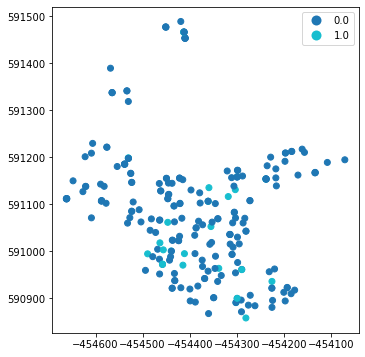

bb: 36.0
ww: 1492.5
bw: 359.5
Pval for BB: 0.008
Pval for BW: 0.869
Globally, join counts suggest positive spatial correlation


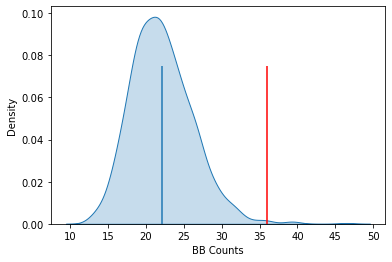

In [25]:
## Global join counts

# Get data
mask = (~db['HiSocEco'].isna())
var = 'HiSocEco'
print('no. of valid observations:',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

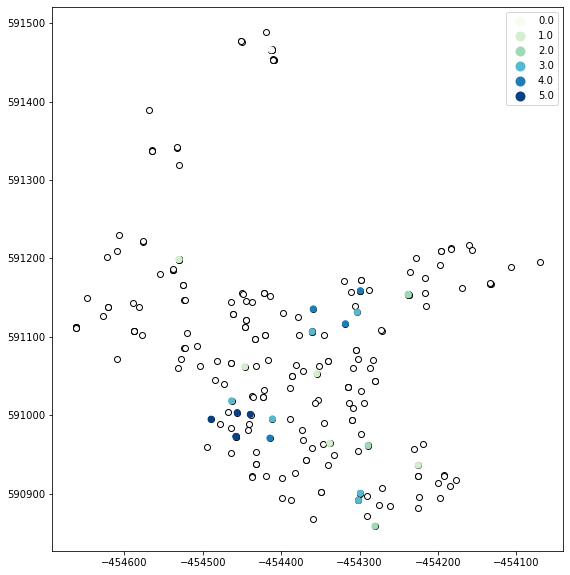

Number of significant points (LJC): 4


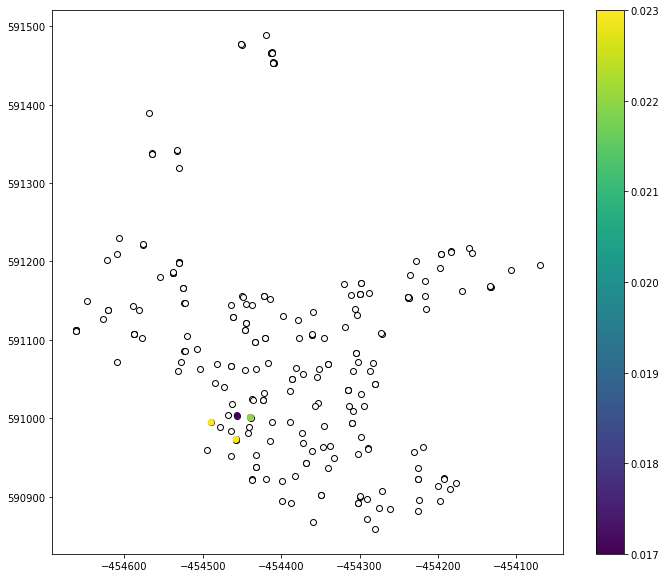

In [26]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_HiScEco'] = np.nan
db['LJC_HiScEco'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_HiScEco_p_sim'] = np.nan
db['LJC_HiScEco_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_HiScEco_W'] = np.nan
db['LJC_HiScEco_W'][db['LJC_HiScEco_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_HiScEco_p_sim'])/signif_thres))*
                                                             db['LJC_HiScEco'])
db['LJC_HiScEco_W'][db['LJC_HiScEco_p_sim']>=signif_thres] = np.square((1-db['LJC_HiScEco_p_sim'])*
                                                              db['LJC_HiScEco'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_HiScEco',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_HiScEco_p_sim_sig'] = np.nan
db['LJC_HiScEco_p_sim_sig'][mask] = 0
db['LJC_HiScEco_p_sim_sig'][db['LJC_HiScEco_p_sim'] < signif_thres] = 1
if db['LJC_HiScEco_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_HiScEco_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_HiScEco_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_HiScEco_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_HiScEco_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

In [27]:
# Save GeoDataFrame with LJC attributes

# Set CRS
db = db.set_crs('epsg:3857',allow_override=True)

# Save
db.to_file(path.join(root_dir,"data_confidential/outputs/LJC/"+
                     basename_azito[:-5]+
                     "_LJC.gpkg"),
           driver='GPKG',
           layer='name',
           epsg='epsg:3857')

## 2.2. Spatial autocorrelation - Williamsville

In [28]:
## Dummy dataframe

# Copy original df
db = willy.copy()

# Set metric CRS
db = db.to_crs(3857)

# Check
db

,uuid,PARENT_KEY,Site,HH_Number,DrinkingWaterGroup,DrinkingWater_Private,DrinkingWater_Public,DrinkingWaterDist,DrinkingWaterPaySocial,DrinkingWaterAvailability,...,San_Record_location-Latitude,San_Record_location-Longitude,Child_U5,D_Case_Tt,D_Case_U5,ID,SurveyArea,WCdirtyB,WCdirtyS,geometry
0,51e3d6c74bba45febd33457e11a9b459,uuid:33942f51-1f03-40ac-80b2-81d09071b605,Williamsville,234,Private,Piped_yard,None,NaN,Y,N,...,NaN,NaN,0.0,1.0,NaN,0,W2,0.0,0.0,POINT (-447932.258 598800.535)
1,51e3d6c74bba45febd33457e11a9b459,uuid:d534e7fc-cad3-49fd-8be2-cab1a34333cc,Williamsville,147,Private,Piped_dwel,None,NaN,Y,N,...,NaN,NaN,0.0,0.0,NaN,1,W3,NaN,NaN,POINT (-448035.426 598825.668)
2,51e3d6c74bba45febd33457e11a9b459,uuid:bc05caff-db45-4a6c-a630-f1cfb9405166,Williamsville,211,Private,Piped_dwel,None,NaN,N,Y,...,NaN,NaN,0.0,0.0,NaN,2,W3,1.0,1.0,POINT (-447950.523 598773.739)
3,51e3d6c74bba45febd33457e11a9b459,uuid:e177d43b-57a4-41a6-bf21-b831841f3c8d,Williamsville,171,Private,Piped_yard,None,NaN,Y,N,...,NaN,NaN,0.0,0.0,NaN,3,W3,0.0,0.0,POINT (-448018.771 598794.824)
4,51e3d6c74bba45febd33457e11a9b459,uuid:fdb8220c-4501-46b5-a237-bbf2b9931b35,Williamsville,305,Private,Piped_yard,None,NaN,None,N,...,NaN,NaN,0.0,0.0,NaN,4,W5,1.0,1.0,POINT (-447864.160 598745.323)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,51e3d6c74bba45febd33457e11a9b459,uuid:477c6247-34a8-4429-8d96-0567c46d2280,Williamsville,284,Private,Piped_dwel,None,NaN,None,N,...,NaN,NaN,0.0,0.0,NaN,296,W5,0.0,0.0,POINT (-447915.491 598767.687)
297,51e3d6c74bba45febd33457e11a9b459,uuid:dd746f0d-4f99-4cb2-94d4-727a3bf760c1,Williamsville,449,Private,Piped_yard,None,NaN,None,N,...,NaN,NaN,0.0,0.0,NaN,297,W4,0.0,0.0,POINT (-447857.952 598804.450)
298,51e3d6c74bba45febd33457e11a9b459,uuid:f301f390-f909-40a3-a99f-32e2d7cdd004,Williamsville,458,Private,Piped_yard,None,NaN,Y,N,...,NaN,NaN,0.0,0.0,NaN,298,W4,0.0,0.0,POINT (-447838.852 598763.771)
299,51e3d6c74bba45febd33457e11a9b459,uuid:5ec3ab1a-d4fa-4914-aacb-84a2f0ebeb23,Williamsville,318,Private,Piped_yard,None,NaN,N,N,...,NaN,NaN,0.0,1.0,NaN,299,W5,1.0,1.0,POINT (-447864.729 598719.755)


Number of observations without any neighbors (islands): 0
Maximum number of neighbours: 16
Mean number of neighbours: 16.0
Minimum number of neighbours: 16
Maximum distance between neighbours: 56.58041024934189
Mean distance between neighbours: 17.422450174833394
Median distance between neighbours: 17.222271631993166


<AxesSubplot:>

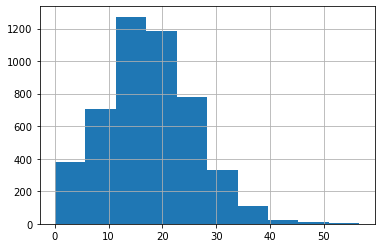

In [29]:
## Spatial matrix (neighbour connections)

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db, k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)


## Matrix characteristics

# Islands
print('Number of observations without any neighbors (islands):', len(wq.islands))

# Min/Max number of neighbours
print('Maximum number of neighbours:', wq.max_neighbors)
print('Mean number of neighbours:', wq.mean_neighbors)
print('Minimum number of neighbours:', wq.min_neighbors)


## Distances beetween points

# Get the coordinates of all observations
coords = weights.util.get_points_array(db.geometry)

# Maximum distance
max_distance = 0
for i, row in enumerate(wq.full()[0]):
    for j, weight in enumerate(row):
        if weight:
            dist = distance.euclidean(coords[i], coords[j])
            if dist > max_distance:
                max_distance = dist                
print('Maximum distance between neighbours:', max_distance)

# Mean & median distances
df_dist = pd.DataFrame()
for i, row in enumerate(wq.full()[0]):
    for j, weight in enumerate(row):
        if weight:
            dist = distance.euclidean(coords[i], coords[j])
            if dist > 0:
                df_dist = df_dist.append([dist])                
df_dist.columns = ['dist']
print('Mean distance between neighbours:', df_dist.dist.mean())
print('Median distance between neighbours:', df_dist.dist.median())

# Plot distance histogram
df_dist.dist.hist()

### 2.2.1. Test local spatial autocorrelation for all cases (Williamsville)

no. observations (general pop.): 301


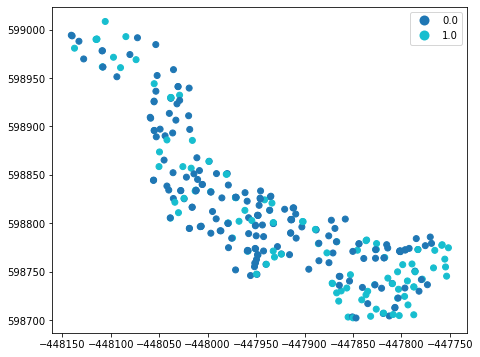

bb: 347.0
ww: 1025.5
bw: 1035.5
Pval for BB: 0.004
Pval for BW: 0.998
Globally, join counts suggest positive spatial correlation


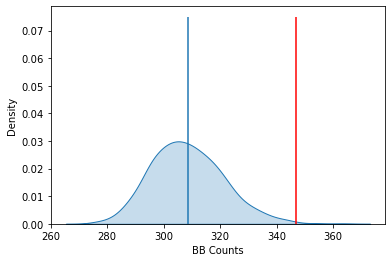

In [30]:
## Global join counts

# Get data
var = 'D_Case_Tt'
print('no. observations (general pop.):',db.shape[0])

# See map 1 (events)
db.plot(aspect=1,
        column=var,
        categorical=True,
        legend=True,
        figsize=(14, 6))
plt.show()

# Set up and run join counts
yb = db[var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb > signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

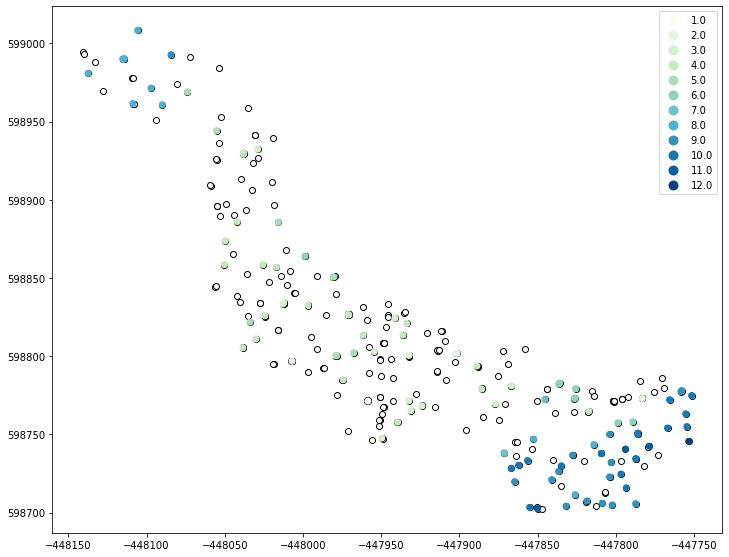

Number of significant points (LJC): 39


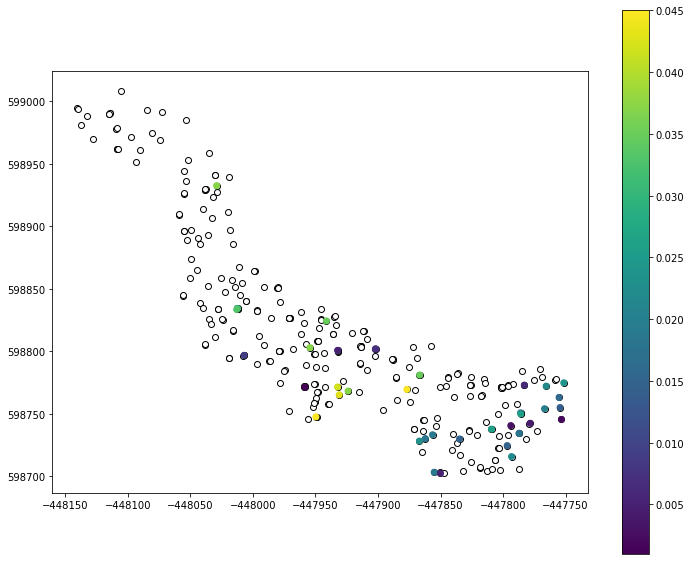

In [31]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
db['LJC_Dia'] = np.nan
db['LJC_Dia'][db[var]==1] = ljc.LJC[db[var]==1].astype('int')
db['LJC_Dia_p_sim'] = np.nan
db['LJC_Dia_p_sim'][db[var]==1] = ljc.p_sim[db[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_Dia_W'] = np.nan
db['LJC_Dia_W'][db['LJC_Dia_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_Dia_p_sim'])/signif_thres))*
                                                     db['LJC_Dia'])
db['LJC_Dia_W'][db['LJC_Dia_p_sim']>=signif_thres] = np.square((1-db['LJC_Dia_p_sim'])*
                                                      db['LJC_Dia'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db.plot(aspect=1,color='white', edgecolor='black', ax=ax)
db.plot(aspect=1,
        column='LJC_Dia',
        categorical=True,
        cmap='GnBu',
        legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_Dia_p_sim_sig'] = 0
db['LJC_Dia_p_sim_sig'][db['LJC_Dia_p_sim'] < signif_thres] = 1
if db['LJC_Dia_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db.plot(aspect=1,color='white', edgecolor='black', ax=ax)
    db[db['LJC_Dia_p_sim_sig']==1].plot(aspect=1,
                                        column='LJC_Dia_p_sim',
                                        legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_Dia_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_Dia_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.2.2. Test local spatial autocorrelation for cases amongst under-5 (Williamsville)

no. observations (concerning under-5 pop.): 128


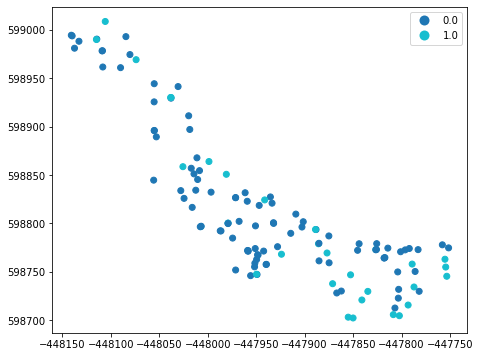

bb: 65.0
ww: 619.5
bw: 339.5
Pval for BB: 0.145
Pval for BW: 0.999
Globally, join counts suggest NO spatial correlation


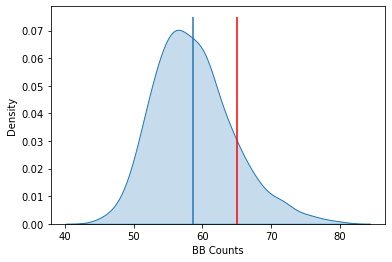

In [32]:
## Global join counts

# Get data
mask = (~db['D_Case_U5'].isna())
var = 'D_Case_U5'
print('no. observations (concerning under-5 pop.):',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb > signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

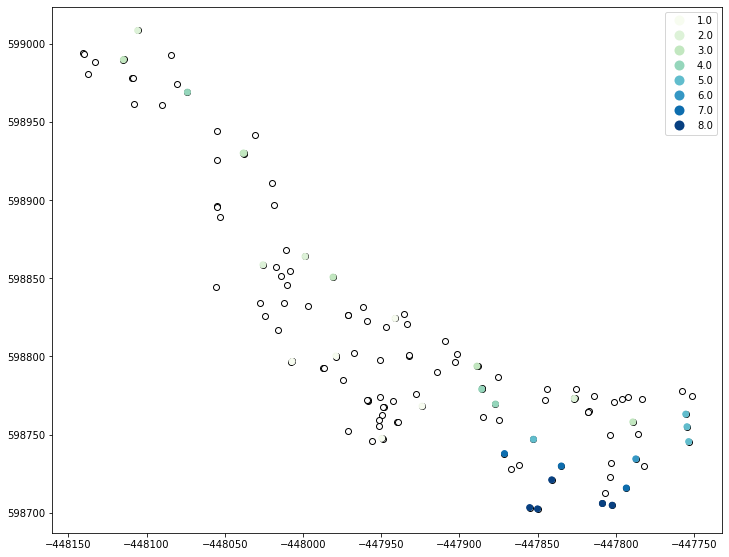

Number of significant points (LJC): 10


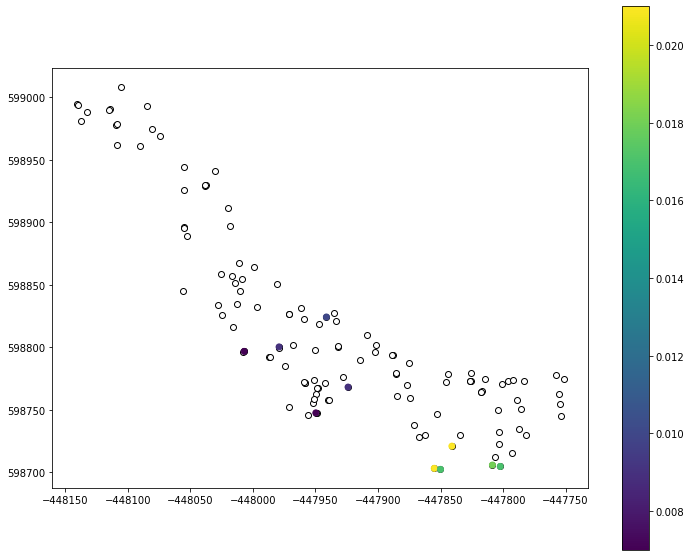

In [33]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_DiaU5'] = np.nan
db['LJC_DiaU5'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_DiaU5_p_sim'] = np.nan
db['LJC_DiaU5_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_DiaU5_W'] = np.nan
db['LJC_DiaU5_W'][db['LJC_DiaU5_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_DiaU5_p_sim'])/signif_thres))*
                                                         db['LJC_DiaU5'])
db['LJC_DiaU5_W'][db['LJC_DiaU5_p_sim']>=signif_thres] = np.square((1-db['LJC_DiaU5_p_sim'])*
                                                          db['LJC_DiaU5'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_DiaU5',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_DiaU5_p_sim_sig'] = np.nan
db['LJC_DiaU5_p_sim_sig'][mask] = 0
db['LJC_DiaU5_p_sim_sig'][db['LJC_DiaU5_p_sim'] < signif_thres] = 1
if db['LJC_DiaU5_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_DiaU5_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_DiaU5_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_DiaU5_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_DiaU5_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.2.3 Test local spatial autocorrelation for access to WASH services (Williamsville)

In [34]:
## WASH components (water, sanitation and hygiene)

# Recode access to "basic water" (following JMP definition) VS any other service type (including unimproved)
wt_basic_mask = (((db["DrinkingWaterGroup"]=='Private')&
                  (db["DrinkingWater_Private"].isin(['Piped_dwel','Piped_yard'])))|
                 ((db["DrinkingWaterGroup"]=='Private')&
                  (db["DrinkingWater_Private"].isin(['Piped_neigh']))&
                  (db["DrinkingWaterDist"]<=30))|
                 ((db["DrinkingWaterGroup"]=='Public')&
                  (db["DrinkingWater_Public"].isin(['Vendor','Ground_tube']))&
                  (db["DrinkingWaterDist"]<=30)))
db["BasicWt"] = np.nan
db["BasicWt"][~db["DrinkingWaterGroup"].isna()] = 0
db["BasicWt"][wt_basic_mask] = 1

# Recode sanitation variable: "basic" sanitation (according to WHO-UNICEF's JMP) VS any other facitilty type (including unimproved and O.D.)
basic_sn_mask = ((((db.ToiletFacilityTYPE=='DryOrCompost')&
                   (db.ToiletFacilityTYPE_Dry.isin(['Dry_ImprSlab',
                                                    'Dry_VIP'])))|
                  ((db.ToiletFacilityTYPE=='Flush')&
                   (db.ToiletFacilityTYPE_Flush.isin(['Flush_piped',
                                                      'Flush_septic_tank',
                                                      'Flush_coveredPit']))))&
                 (db.ToiletROOF=='Y')&
                 (db.ToiletFacilitySHARE=='N'))
db["BasicSan"] = np.nan
db["BasicSan"][(~db.ToiletFacility.isna())] = 0
db["BasicSan"][basic_sn_mask] = 1

# Recode "basic" hygiene (according to WHO-UNICEF's JMP)
basic_hg_mask = ((db["ObsHandWashWATER"]=='Water_OK')& # water available at the moment of the survey
                 (db["ObsHandWashSOAP"]=='SoapOrDeterg')& # soap (or equivalent) available at the moment of the survey
                 (db["ObsHandWashPLACE"]=='Obs_Fixed')) # presence of fixed structure to wash hands
db["BasicHyg"] = np.nan
db["BasicHyg"][(~db["ObsHandWashWATER"].isna())&(~db["ObsHandWashSOAP"].isna())&(~db["ObsHandWashPLACE"].isna())] = 0
db["BasicHyg"][basic_hg_mask] = 1


## General WASH

# Recode access to all 3 basic WASH services (water, sanitation and hygiene)
basic_wash_mask = ((db["BasicWt"]==1)&
                   (db["BasicSan"]==1)&
                   (db["BasicHyg"]==1))
db["BasicWASH"] = np.nan
db["BasicWASH"][(~db["BasicWt"].isna())&(~db["BasicSan"].isna())&(~db["BasicHyg"].isna())] = 0
db["BasicWASH"][basic_wash_mask] = 1

no. of valid observations: 298


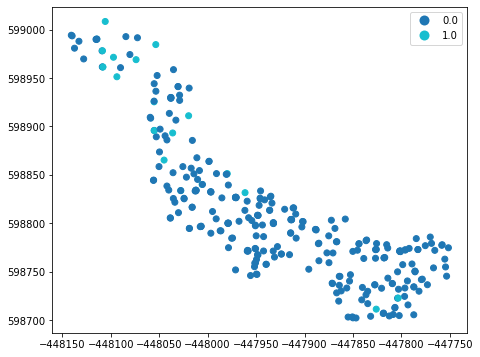

bb: 28.0
ww: 2090.0
bw: 266.0
Pval for BB: 0.001
Pval for BW: 0.998
Globally, join counts suggest positive spatial correlation


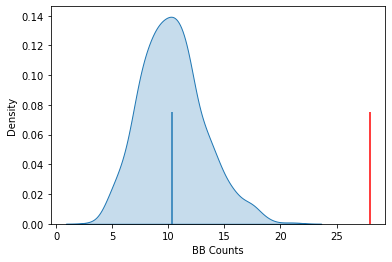

In [35]:
## Global join counts

# Get data
mask = (~db['BasicWASH'].isna())
var = 'BasicWASH'
print('no. of valid observations:',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb > signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

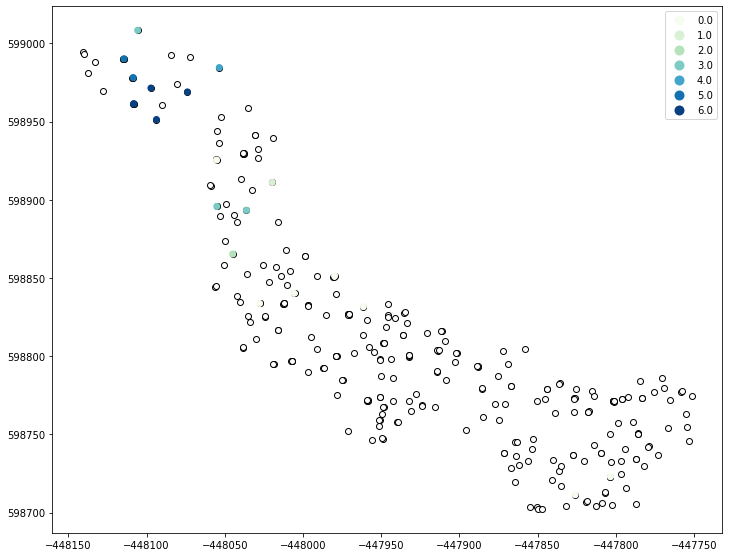

Number of significant points (LJC): 8


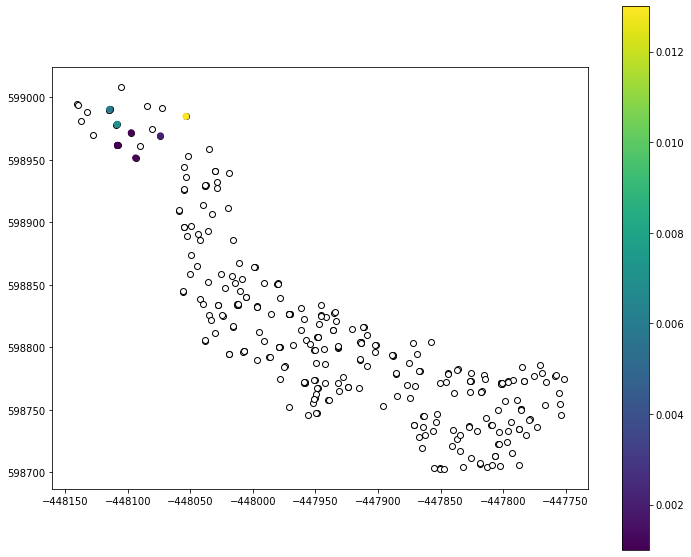

In [36]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_BsWASH'] = np.nan
db['LJC_BsWASH'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_BsWASH_p_sim'] = np.nan
db['LJC_BsWASH_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_BsWASH_W'] = np.nan
db['LJC_BsWASH_W'][db['LJC_BsWASH_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_BsWASH_p_sim'])/signif_thres))*
                                                           db['LJC_BsWASH'])
db['LJC_BsWASH_W'][db['LJC_BsWASH_p_sim']>=signif_thres] = np.square((1-db['LJC_BsWASH_p_sim'])*
                                                            db['LJC_BsWASH'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_BsWASH',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_BsWASH_p_sim_sig'] = np.nan
db['LJC_BsWASH_p_sim_sig'][mask] = 0
db['LJC_BsWASH_p_sim_sig'][db['LJC_BsWASH_p_sim'] < signif_thres] = 1
if db['LJC_BsWASH_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_BsWASH_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_BsWASH_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_BsWASH_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_BsWASH_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.2.4 Test local spatial autocorrelation for precarious housing materials (Williamsville)

In [37]:
# Recode precarious housing (based on dwelling's materials)
prec_h_mask = ((db["HHEXTWALLS"].isin(['Stone_mud','ReusedWoodOrBamboo','Metal']))|
               (db["HHFLOOR"].isin(['Other']))|
               (db["HHROOF"].isin(['Rustic_metal','Rustic_toles_fibr','Rustic_planks','Rustic_plastic'])))
db["PrecHHMat"] = np.nan
db["PrecHHMat"][(~db["HHEXTWALLS"].isna())&(~db["HHFLOOR"].isna())&(~db["HHROOF"].isna())] = 0
db["PrecHHMat"][prec_h_mask] = 1

no. of valid observations: 301


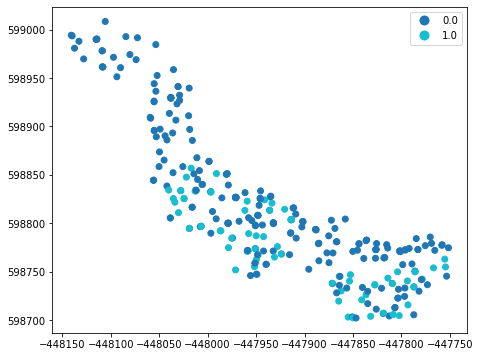

bb: 255.0
ww: 1400.5
bw: 752.5
Pval for BB: 0.001
Pval for BW: 1.0
Globally, join counts suggest positive spatial correlation


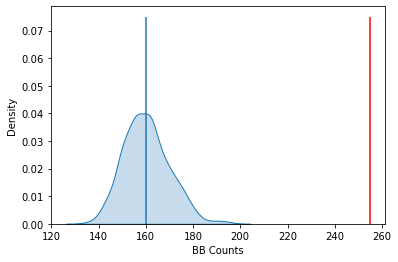

In [38]:
## Global join counts

# Get data
mask = (~db['PrecHHMat'].isna())
var = 'PrecHHMat'
print('no. of valid observations:',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb > signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

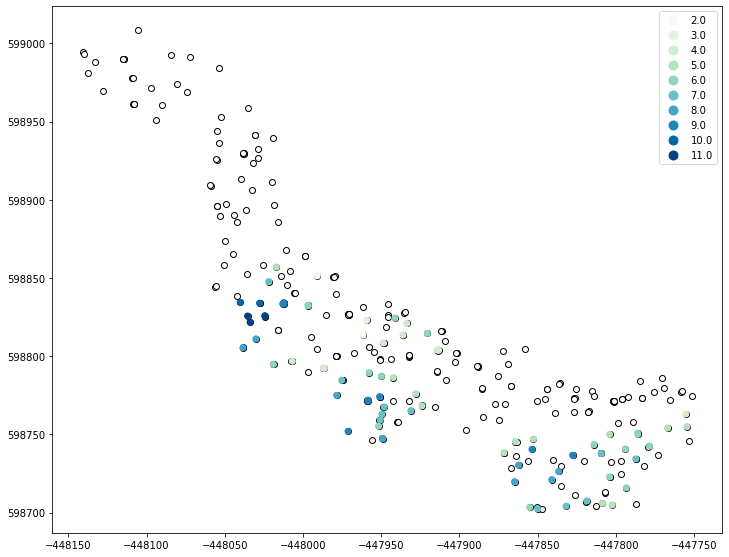

Number of significant points (LJC): 25


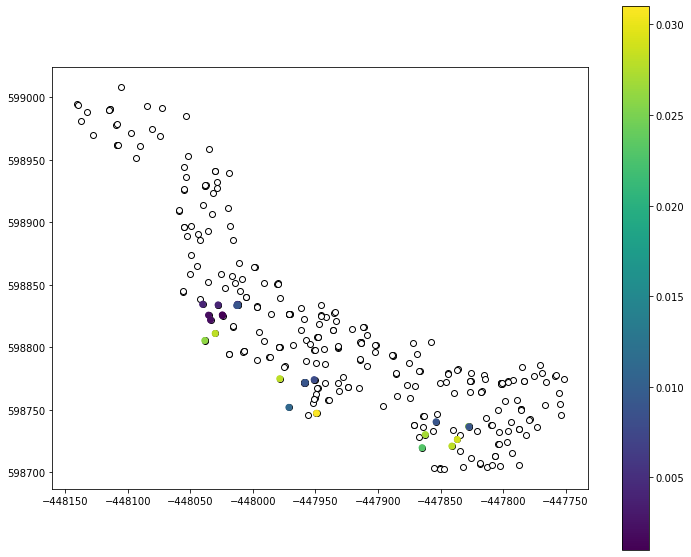

In [39]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_PrMat'] = np.nan
db['LJC_PrMat'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_PrMat_p_sim'] = np.nan
db['LJC_PrMat_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_PrMat_W'] = np.nan
db['LJC_PrMat_W'][db['LJC_PrMat_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_PrMat_p_sim'])/signif_thres))*
                                                                  db['LJC_PrMat'])
db['LJC_PrMat_W'][db['LJC_PrMat_p_sim']>=signif_thres] = np.square((1-db['LJC_PrMat_p_sim'])*
                                                                   db['LJC_PrMat'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_PrMat',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_PrMat_p_sim_sig'] = np.nan
db['LJC_PrMat_p_sim_sig'][mask] = 0
db['LJC_PrMat_p_sim_sig'][db['LJC_PrMat_p_sim'] < signif_thres] = 1
if db['LJC_PrMat_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_PrMat_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_PrMat_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_PrMat_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_PrMat_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.2.5 Test local spatial autocorrelation for indoors cooking (Williamsville)

In [40]:
# Cooking area (whether cooking is done inside dwelling or elsewhere)

# Note: on the contrary of Azito, here we observe households that cooked INSIDE
# this is necessary because there are more households cooking inside than outside the dwelling
# ('1' values must be minority in LJC analyses)

# Recode cooking area
cook_mask = (db["HHCOOKING"].isin(['House']))# cooking done INSIDE dwelling
db["CookInsd"] = np.nan
db["CookInsd"][~db["HHCOOKING"].isna()] = 0
db["CookInsd"][cook_mask] = 1

no. of valid observations: 301


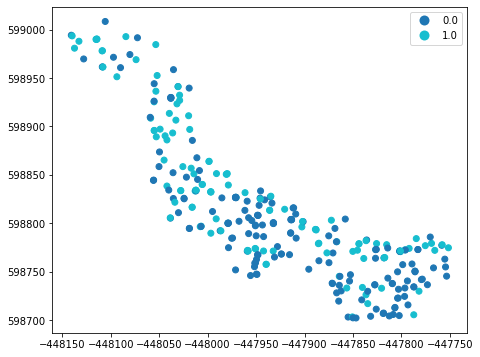

bb: 521.5
ww: 880.5
bw: 1006.0
Pval for BB: 0.001
Pval for BW: 1.0
Globally, join counts suggest positive spatial correlation


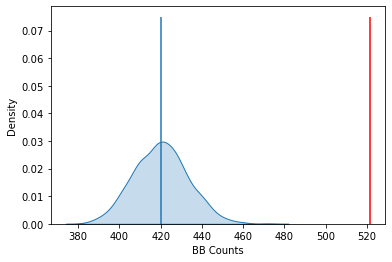

In [41]:
## Global join counts

# Get data
mask = (~db['CookInsd'].isna())
var = 'CookInsd'
print('no. of valid observations:',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb > signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

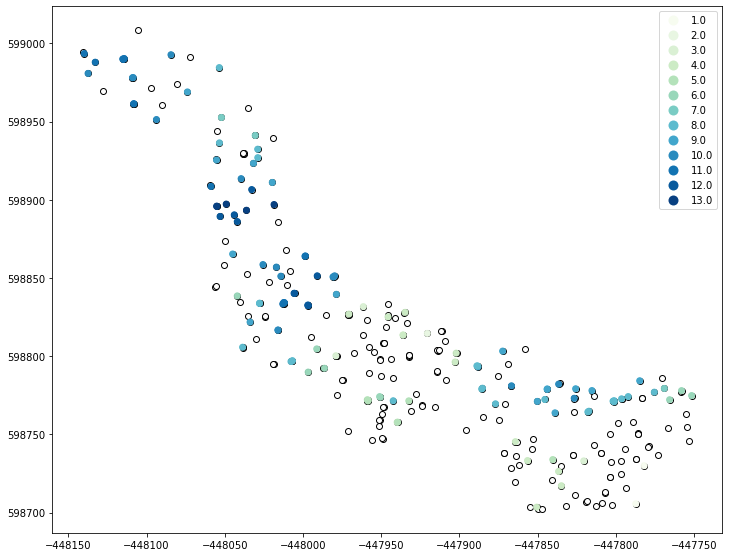

Number of significant points (LJC): 42


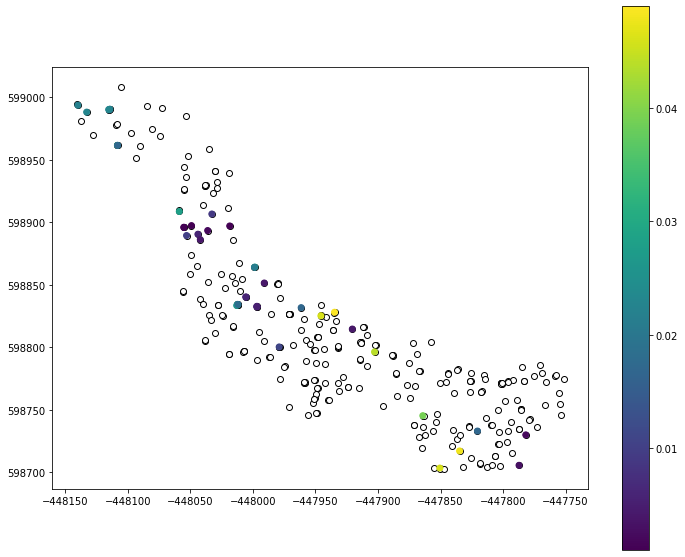

In [42]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_CkInd'] = np.nan
db['LJC_CkInd'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_CkInd_p_sim'] = np.nan
db['LJC_CkInd_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_CkInd_W'] = np.nan
db['LJC_CkInd_W'][db['LJC_CkInd_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_CkInd_p_sim'])/signif_thres))*
                                                                  db['LJC_CkInd'])
db['LJC_CkInd_W'][db['LJC_CkInd_p_sim']>=signif_thres] = np.square((1-db['LJC_CkInd_p_sim'])*
                                                                   db['LJC_CkInd'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_CkInd',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_CkInd_p_sim_sig'] = np.nan
db['LJC_CkInd_p_sim_sig'][mask] = 0
db['LJC_CkInd_p_sim_sig'][db['LJC_CkInd_p_sim'] < signif_thres] = 1
if db['LJC_CkInd_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_CkInd_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_CkInd_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_CkInd_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_CkInd_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.2.6 Test local spatial autocorrelation for lack of water (Williamsville)

In [43]:
## Water availability in the month preceding the survey

# Note: on the contrary of the aORs in Notebooks 1a & b, here we observe households that LACKED water
# this is necessary because there are more households with sufficient water than lacking water
# ('1' values must be minority in LJC analyses)

# Recode water availability in the past month (self-reported)
wt_avail_mask = (db["DrinkingWaterAvailability"]=='Y') # LACK of water in the previous month
db["AvailblWtM"] = np.nan
db["AvailblWtM"][~db["DrinkingWaterAvailability"].isna()] = 0
db["AvailblWtM"][wt_avail_mask] = 1

no. of valid observations: 301


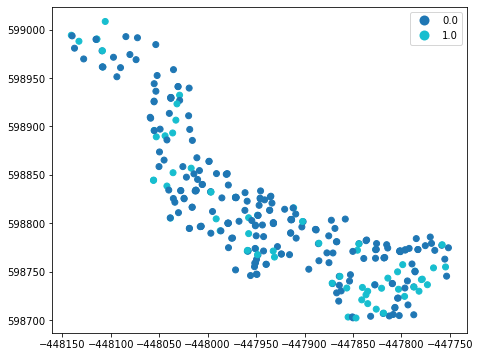

bb: 158.5
ww: 1487.5
bw: 762.0
Pval for BB: 0.001
Pval for BW: 1.0
Globally, join counts suggest positive spatial correlation


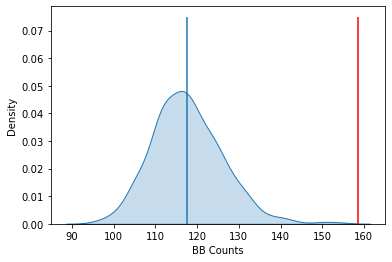

In [44]:
## Global join counts

# Get data
mask = (~db['AvailblWtM'].isna())
var = 'AvailblWtM'
print('no. of valid observations:',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb > signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

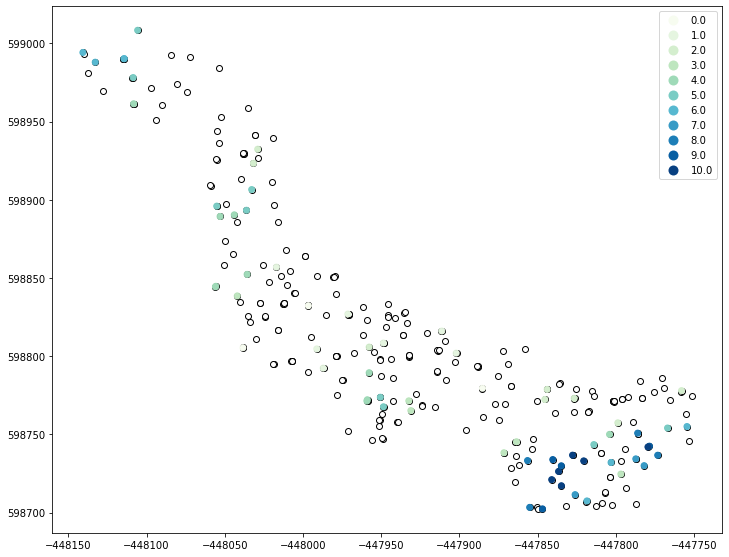

Number of significant points (LJC): 24


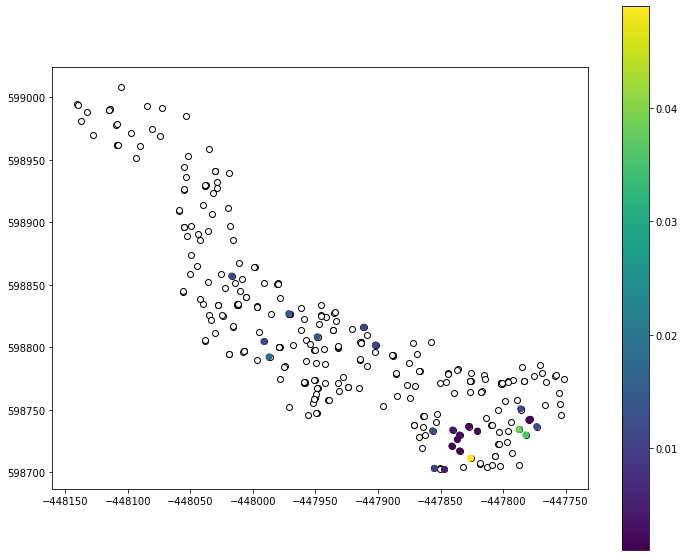

In [45]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_WtAvbM'] = np.nan
db['LJC_WtAvbM'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_WtAvbM_p_sim'] = np.nan
db['LJC_WtAvbM_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_WtAvbM_W'] = np.nan
db['LJC_WtAvbM_W'][db['LJC_WtAvbM_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_WtAvbM_p_sim'])/signif_thres))*
                                                           db['LJC_WtAvbM'])
db['LJC_WtAvbM_W'][db['LJC_WtAvbM_p_sim']>=signif_thres] = np.square((1-db['LJC_WtAvbM_p_sim'])*
                                                            db['LJC_WtAvbM'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_WtAvbM',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_WtAvbM_p_sim_sig'] = np.nan
db['LJC_WtAvbM_p_sim_sig'][mask] = 0
db['LJC_WtAvbM_p_sim_sig'][db['LJC_WtAvbM_p_sim'] < signif_thres] = 1
if db['LJC_WtAvbM_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_WtAvbM_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_WtAvbM_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_WtAvbM_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_WtAvbM_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

### 2.2.7 Test local spatial autocorrelation for 'high' socioeconomic status (Williamsville)

In [46]:
# Set threshold for asset-based wealth
df_c = data_HH_tot.copy()
df_c["ItemsScore"]=(df_c["HHITEMS/Computer"]+df_c["HHITEMS/Electricity"]+
                    df_c["HHITEMS/Internet"]+df_c["HHITEMS/Oven"]+
                    df_c["HHITEMS/Radio"]+df_c["HHITEMS/Refrigerator"]+
                    df_c["HHITEMS/Smartphone"]+df_c["HHITEMS/Television"])
df_c["ItemsScore"][(df_c["HHITEMS/Noitems"]==1)] = 0
df_c["ItemsScore"][(df_c["HHITEMS/NA"]==1)] = np.nan
wealth_threshold = df_c["ItemsScore"].mean() # Number of items above the mean (of all the surveyed households)

# Wealth based on households assets
db["ItemsScore"]=(db["HHITEMS/Computer"]+db["HHITEMS/Electricity"]+
                  db["HHITEMS/Internet"]+db["HHITEMS/Oven"]+
                  db["HHITEMS/Radio"]+db["HHITEMS/Refrigerator"]+
                  db["HHITEMS/Smartphone"]+db["HHITEMS/Television"])
db["ItemsScore"][(db["HHITEMS/Noitems"]==1)] = 0
db["ItemsScore"][(db["HHITEMS/NA"]==1)] = np.nan
wt_hdhyg_mask = (db["ItemsScore"]>wealth_threshold)# Number of items above the mean (of all the surveyed households)
db["WealthyHH"] = np.nan
db["WealthyHH"][~db["ItemsScore"].isna()] = 0
db["WealthyHH"][wt_hdhyg_mask] = 1

# Education level of heads of households
src = data_IND_tot[data_IND_tot.Relation_to_HH=='Head'][['PARENT_KEY',
                                                         'School_past']]# subset ed. level of HH
# Recode education level of heads of households
src['SecEduHH'] = np.nan
src['SecEduHH'][src['School_past'].isin(['No_Edu',
                                         'Early_CdE',
                                         'Primary',
                                         'Coranic'])] = 0 # up to primary education
src['SecEduHH'][src['School_past'].isin(['Secondary',
                                         'Secondary_1',
                                         'Secondary_2',
                                         'High_Ed'])] = 1 # secondary or higher education
src = src[~src.SecEduHH.isna()]
# In case a same household has 2 heads, merge lines
src = src[['SecEduHH','PARENT_KEY']].groupby(by="PARENT_KEY").max().reset_index()
# Attribute education level of heads of households
db = db.merge(src,on="PARENT_KEY",how='left')


## Determine socioeconomic level

# 'high' stratum: asset-based wealth higher than averaga and secondary education attained
hi_soceco_mask = ((db["WealthyHH"]==1)&(db["SecEduHH"]==1))
db["HiSocEco"] = np.nan
db["HiSocEco"][(~db["WealthyHH"].isna())&(~db["SecEduHH"].isna())] = 0
db["HiSocEco"][hi_soceco_mask] = 1

no. of valid observations: 264


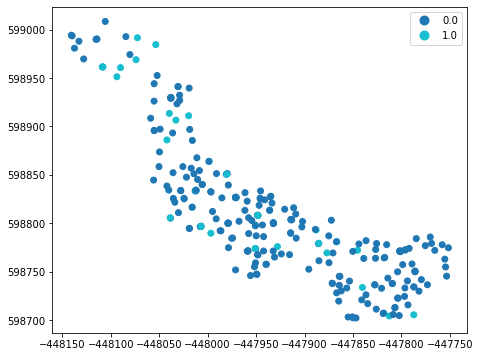

bb: 40.5
ww: 1641.0
bw: 430.5
Pval for BB: 0.02
Pval for BW: 0.952
Globally, join counts suggest positive spatial correlation


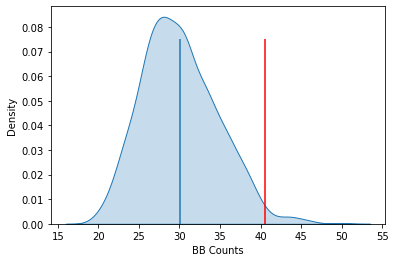

In [47]:
## Global join counts

# Get data
mask = (~db['HiSocEco'].isna())
var = 'HiSocEco'
print('no. of valid observations:',db[mask].shape[0])

# See map 1 (events)
db[mask].plot(aspect=1,
              column=var,
              categorical=True,
              legend=True,
              figsize=(14, 6))
plt.show()

# Set up KNN matrix, based on point geodataframe
wq = weights.KNN.from_dataframe(db[mask], k=n_neighbours)
wq.transform = 'b' # binary matrix (0/1)

# Set up and run join counts
yb = db[mask][var] # binary variable
jc = esda.join_counts.Join_Counts(yb, wq) # run join counts

# See results
print('bb:',jc.bb)
print('ww:',jc.ww)
print('bw:',jc.bw)

# Plot results for 'bb' ('11', or case-case)
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
print('Pval for BB:',jc.p_sim_bb)
print('Pval for BW:',jc.p_sim_bw)

# Inference:
if (jc.p_sim_bb < signif_thres) and (jc.p_sim_bw > signif_thres):
    print("Globally, join counts suggest positive spatial correlation")
elif (jc.p_sim_bb > signif_thres) and (jc.p_sim_bw < signif_thres):
    print("Globally, join counts suggest negative spatial correlation")
else:
    print("Globally, join counts suggest NO spatial correlation")

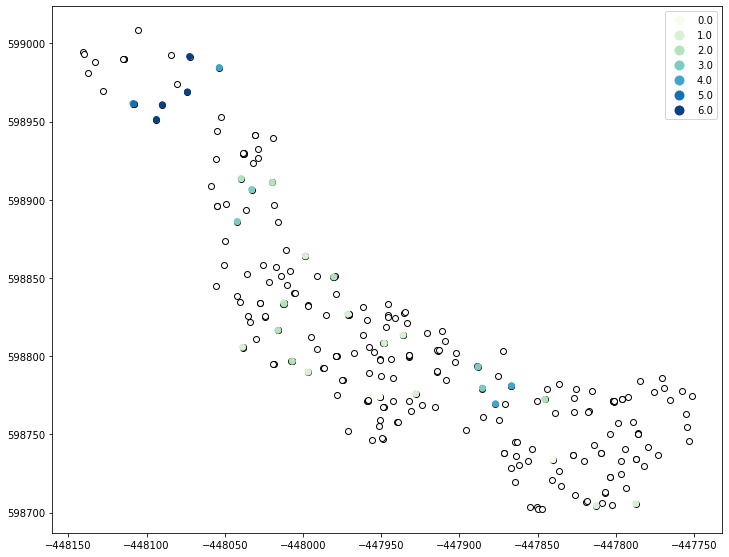

Number of significant points (LJC): 5


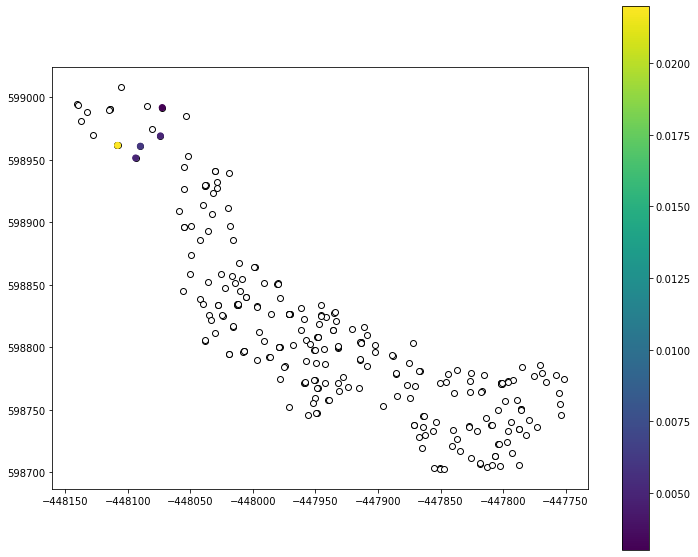

In [48]:
## Local Join counts

# Run local join counts
ljc = esda.join_counts_local.Join_Counts_Local(connectivity=wq).fit(yb) # run join counts

# Set LJC attributes
dummy = db[mask]
db['LJC_HiScEco'] = np.nan
db['LJC_HiScEco'][(mask)&(db[var]==1)] = ljc.LJC[dummy[var]==1].astype('int')
db['LJC_HiScEco_p_sim'] = np.nan
db['LJC_HiScEco_p_sim'][(mask)&(db[var]==1)] = ljc.p_sim[dummy[var]==1]

# Set LJC weights (for heatmap done with QGIS)
db['LJC_HiScEco_W'] = np.nan
db['LJC_HiScEco_W'][db['LJC_HiScEco_p_sim']<signif_thres] = np.square((1+((signif_thres-db['LJC_HiScEco_p_sim'])/signif_thres))*
                                                             db['LJC_HiScEco'])
db['LJC_HiScEco_W'][db['LJC_HiScEco_p_sim']>=signif_thres] = np.square((1-db['LJC_HiScEco_p_sim'])*
                                                              db['LJC_HiScEco'])

# Plot LJC
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
db[mask].plot(aspect=1,
              column='LJC_HiScEco',
              categorical=True,
              cmap='GnBu',
              legend=True, ax=ax)
plt.show()

# Plot LJC - only significant p-values (p<0.05)
db['LJC_HiScEco_p_sim_sig'] = np.nan
db['LJC_HiScEco_p_sim_sig'][mask] = 0
db['LJC_HiScEco_p_sim_sig'][db['LJC_HiScEco_p_sim'] < signif_thres] = 1
if db['LJC_HiScEco_p_sim_sig'].max() == 1:
    fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
    db[mask].plot(aspect=1, color='white', edgecolor='black', ax=ax)
    db[db['LJC_HiScEco_p_sim_sig']==1].plot(aspect=1,
                                          column='LJC_HiScEco_p_sim',
                                          legend=True, ax=ax)
    print("Number of significant points (LJC):",db[db['LJC_HiScEco_p_sim_sig']==1].shape[0])
else:
    print("Number of significant points is",db[db['LJC_HiScEco_p_sim_sig']==1].shape[0],
          ">> Hence, no significance map")

In [49]:
# Save GeoDataFrame with LJC attributes

# Set CRS
db = db.set_crs('epsg:3857',allow_override=True)

# Save
db.to_file(path.join(root_dir,"data_confidential/outputs/LJC/"+
                     basename_willy[:-5]+
                     "_LJC.gpkg"),
           driver='GPKG',
           layer='name',
           epsg='epsg:3857')